In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pickle
import sys, os
import time
import libcamodocal
import matplotlib.pyplot as plt
import cv2
import quaternion
from IPython import display
from IPython.display import clear_output
import glob
import calib_utils
import calib

In [3]:
# define cb pattern
cb_pattern = (5,6)

#define checkerboard pattern size [m]
cb_size = .04
# generate pattern_3d
pattern_3d = np.zeros((np.prod(cb_pattern), 3), np.float32)
pattern_3d[:, :2] = np.indices(cb_pattern).T.reshape(-1, 2)
pattern_3d *= cb_size
pattern_3d = np.transpose(pattern_3d)

# load calib data
#calib_data = pickle.load(open("./../data/calibdata_22_03_2022_21_19_53_pick.pkl", "rb" ))
#calib_data = pickle.load( open("/home/ralfi/Desktop/calibdata_29_03_2022_19_39_11.pkl", "rb" ))
calib_data_base_path = "/home/ralfi/Desktop/calib_data/charuco/"
pkl_path =  glob.glob(calib_data_base_path + '*.pkl')

calib_data_i = []
rgbs_all, poses = [], []
for pk in pkl_path:
    try:

        calib_data_i = pickle.load(open(pk, "rb" ))

        for c in calib_data_i['data']:
            poses.append(c['pose'])
            rgbs = []
            for rgb_i in c['cam_data']:
                rgbs.append(rgb_i['rgb'].numpy())
            rgbs_all.append(rgbs)
    except:
        pass
    
cam_intrinsics = calib_data_i['data'][0]['cam_data'][0]['cam_params']['intrinsics']
K = np.array([[cam_intrinsics['fx'],0,cam_intrinsics['cx']],[0,cam_intrinsics['fy'],cam_intrinsics['cy']],[0,0,1]], dtype = np.float64)
dist = np.array([0.15534031, -0.45483516, -0.00437611, -0.00270608, 0.29149164])
# Setup Camera intrinsics
print(K)
print(np.transpose(dist))

[[930.08795166   0.         613.2666626 ]
 [  0.         930.21618652 349.65106201]
 [  0.           0.           1.        ]]
[ 0.15534031 -0.45483516 -0.00437611 -0.00270608  0.29149164]


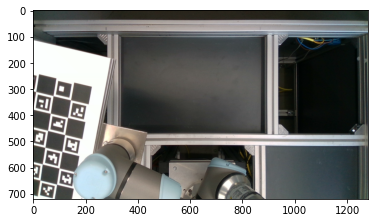

In [4]:
plt.imshow(rgbs_all[8][0])

In [5]:
N = len(rgbs_all[0])

#Setup HEC Solver
setup = calib.calibrator.Setup(2)
cgi_cal = calib.calibrator.HandEyeCalibrator(setup)

# Setup Marker
marker_type = 'charuco'
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
board = cv2.aruco.CharucoBoard_create(7, 6, 0.04, 0.031, aruco_dict)

# lists for graph hand eye
list_points_2d, obj_poses, obj_poses_inv, hand_poses, hand_poses_inv = [], [], [], [], []

for i in range(N):
    
    frames = np.array(rgbs_all[i])
    #calculate cam_pose
    
    p_tvec_median, p_rvec_median, homTF_obj, corners_median, c_corner_median, points_2d_median, imgs = calib_utils.estimate_cam_pose_charuco(frames, K, dist, board, aruco_dict, subpixel_accuracy = True, debug = False)
    
    #calculate hand psoe
    pose_homTF = calib_utils.pose7d2homTF(poses[i])
    pose_homTF_inv = np.linalg.inv(pose_homTF)
    homTF_obj_inv = np.linalg.inv(homTF_obj)
        
    #list_points_2d
    #if(len(c_corner_median) == 30):
    if True:
        list_points_2d.append(np.transpose((np.array(np.copy(c_corner_median))).reshape(1,2, len(c_corner_median))[0]))
        obj_poses.append(homTF_obj)
        obj_poses_inv.append(homTF_obj_inv)
        hand_poses.append(pose_homTF)
        hand_poses_inv.append(pose_homTF_inv)
    
        cgi_cal.add_sample(pose_homTF_inv, homTF_obj)

In [8]:
list_points_2d = []
list_points_2d.append(np.transpose((np.array(np.copy(corners_median))).reshape(1,2, len(corners_median))[0]))

In [6]:
cv2.aruco.CharucoBoard_create??

Docstring:
CharucoBoard_create(squaresX, squaresY, squareLength, markerLength, dictionary) -> retval
.   * @brief Create a CharucoBoard object
.        *
.        * @param squaresX number of chessboard squares in X direction
.        * @param squaresY number of chessboard squares in Y direction
.        * @param squareLength chessboard square side length (normally in meters)
.        * @param markerLength marker side length (same unit than squareLength)
.        * @param dictionary dictionary of markers indicating the type of markers.
.        * The first markers in the dictionary are used to fill the white chessboard squares.
.        * @return the output CharucoBoard object
.        *
.        * This functions creates a CharucoBoard object given the number of squares in each direction
.        * and the size of the markers and chessboard squares.
Type:      builtin_function_or_method


In [9]:
list_points_2dcorners_median

[array([], shape=(0, 2), dtype=float64)]

In [7]:
lol = libcamodocal.py_camodocal_calibration(hand_poses_inv, obj_poses_inv, {}, False)
print(lol)

[[-0.65799659 -0.7149954   0.23626694 -0.10189888]
 [-0.4699286   0.14472807 -0.8707588   0.35416941]
 [ 0.58839408 -0.68398491 -0.43122737  0.24954011]
 [ 0.          0.          0.          1.        ]]


In [8]:
np.linalg.inv(lol)

array([[-0.65799659, -0.4699286 ,  0.58839408, -0.0474427 ],
       [-0.7149954 ,  0.14472807, -0.68398491,  0.04656618],
       [ 0.23626694, -0.8707588 , -0.43122737,  0.44007999],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [9]:
dani = cgi_cal.solve(calib.solver.Daniilidis1999)
print("dani\n", dani)

tsai = cgi_cal.solve(calib.solver.TsaiLenz1989)
print("tsai\n", tsai)

park = cgi_cal.solve(calib.solver.ParkBryan1994)
print("park\n", park)

dani
 [[-0.02343246 -0.99880167  0.04296689  0.33982649]
 [-0.99961154  0.02405683  0.01407237  0.00856915]
 [-0.01508915 -0.04262044 -0.99897738  0.93917286]
 [ 0.          0.          0.          1.        ]]
tsai
 [[-0.05322534 -0.99593116  0.07271992  0.35475596]
 [-0.99856738  0.05348428  0.00161673  0.01722088]
 [-0.00549952 -0.07252969 -0.99735109  0.94614021]
 [ 0.          0.          0.          1.        ]]
park
 [[-0.02072657 -0.99906025  0.03806618  0.35525941]
 [-0.99957861  0.02148121  0.01952341  0.01911081]
 [-0.02032277 -0.03764549 -0.99908448  0.95309985]
 [ 0.          0.          0.          1.        ]]


In [14]:
print("dani\n", calib_utils.homTF2pose7d(dani))

print("tsai\n", calib_utils.homTF2pose7d(tsai))

print("park\n", calib_utils.homTF2pose7d(park))


dani
 [ 0.38620155  0.05543622  1.02968311 -0.00256243 -0.72661778  0.68702441
 -0.00418264]
tsai
 [ 0.458301   -0.01549335  0.66011709 -0.20199569 -0.72454425  0.5418363
  0.37502905]
park
 [ 0.37583787  0.03963857  1.00675225 -0.00146047 -0.73203195  0.68126868
 -0.00027964]


In [15]:
# generate pattern_3d
cb_pattern = (5, 6)
pattern_3d = np.zeros((np.prod(cb_pattern), 3), np.float32)
pattern_3d[:, :2] = np.indices(cb_pattern).T.reshape(-1, 2)
pattern_3d *= cb_size
pattern_3d = np.transpose(pattern_3d)

In [16]:
# setup pars
params={}
params['pattern2d_inf_scale'] = 1e-6
params['world2hand_inf_scale_trans'] = 1e-6
params['world2hand_inf_scale_rot'] = 1
params['num_iterations'] = 1000*8192
params['solver_name'] = "lm_var_cholmod"
params['robust_kernel_handpose'] = "Huber"
params['robust_kernel_projection'] = "Huber"
params['robust_kernel_handpose_delta'] = 1e-6
params['robust_kernel_projection_delta'] = 1e-6

init_object2world = np.eye(4)

init_hand2eye = park

#hand2eye_visp, object2world_visp = cb.py_spatial_calibration_graph(K, pattern_3d, list_hand_pose_rotm, list_points_2d, init_hand2eye, init_object2world, True, params)

hand2eye_graph, object2world_graph = calib.py_spatial_calibration_graph(K, pattern_3d, hand_poses_inv, list_points_2d, init_hand2eye, init_object2world, True, params)


print('init park:')
print(park)
print('hand2eye_graph:')
print(hand2eye_graph)
print('hand2eye_graph inv:')
print(np.linalg.inv(hand2eye_graph))
#print('object2world_graph:')
#print(object2world_graph)

#diff = abs(np.linalg.inv(hand2eye_graph) - calib_utils.pose7d2homTF(calib_data['ground_truth']))
#print('diff:')
#print(diff)

init park:Using initGuess to warmstart graph calibration
construct solver... done
installing parameters... done
optimizing...
iterations: -1/8192000
chi2: (before)0 -> (after)0

[[ 0.07174581 -0.9974217  -0.00158055  0.37583787]
 [-0.99742006 -0.0717417  -0.00251924  0.03963857]
 [ 0.00239936  0.00175721 -0.99999558  1.00675225]
 [ 0.          0.          0.          1.        ]]
hand2eye_graph:
[[ 0.07174581 -0.9974217  -0.00158055  0.37583787]
 [-0.99742006 -0.0717417  -0.00251924  0.03963857]
 [ 0.00239936  0.00175721 -0.99999558  1.00675225]
 [ 0.          0.          0.          1.        ]]
hand2eye_graph inv:
[[ 0.07174581 -0.99742006  0.00239936  0.01015596]
 [-0.9974217  -0.0717417   0.00175721  0.37594351]
 [-0.00158055 -0.00251924 -0.99999558  1.00744169]
 [ 0.          0.          0.          1.        ]]


# Using CHOLMOD poseDim -1 landMarkDim -1 blockordering 1
virtual bool g2o::SparseOptimizer::initializeOptimization(g2o::HyperGraph::VertexSet&, int): Attempt to initialize an empty graph
virtual int g2o::SparseOptimizer::optimize(int, bool): 0 vertices to optimize, maybe forgot to call initializeOptimization()


In [10]:
np.shape(list_points_2d)

(6, 2, 30)

In [ ]:
calib.py

In [11]:
list_points_2d

[array([[620.9708 , 415.4571 , 656.65216, 381.58957, 692.4861 , 347.42697,
         728.7089 , 313.09793, 764.9932 , 278.5236 , 802.1119 , 243.58801,
         586.8896 , 379.856  , 622.38873, 345.91342, 658.1631 , 311.63773,
         694.0891 , 277.11337, 730.3939 , 242.55296, 767.1899 , 207.2807 ,
         552.82587, 344.23294, 588.1153 , 310.1304 , 623.8254 , 275.7659 ],
        [659.6683 , 241.25807, 695.8607 , 206.2662 , 732.4147 , 171.05496,
         518.72015, 308.5646 , 553.95166, 274.39566, 589.5393 , 239.98022,
         625.20636, 205.26646, 661.2326 , 170.23196, 697.7834 , 134.64296,
         484.63794, 273.03854, 519.80084, 238.78003, 555.20874, 204.14746,
         590.843  , 169.29544, 626.7162 , 133.96507, 663.02026,  98.20243]],
       dtype=float32),
 array([[485.68665, 440.69916, 516.0806 , 399.70496, 546.9726 , 358.29788,
         577.9555 , 316.69485, 609.245  , 274.7391 , 640.9043 , 232.28047,
         444.51895, 409.3671 , 474.83047, 368.41748, 505.42236, 326.9846 ,

In [3]:
calib.py_pose_graph_calibration()

TypeError: py_pose_graph_calibration(): incompatible function arguments. The following argument types are supported:
    1. (arg0: numpy.ndarray[float64[3, 3]], arg1: List[numpy.ndarray[float64[4, 4]]], arg2: List[numpy.ndarray[float64[4, 4]]], arg3: numpy.ndarray[float64[4, 4]], arg4: numpy.ndarray[float64[4, 4]], arg5: bool, arg6: dict) -> tuple

Invoked with: 

Using Subpixel accuracy
Translation : [[-0.09098327]
 [ 0.12625851]
 [ 0.72443665]]
Rotation    : [[-2.77546646]
 [ 1.38387121]
 [ 0.1083084 ]]
Distance from camera: 0.7409639881576993 m


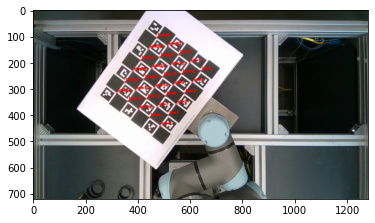

In [12]:
frame = rgbs_all[2][0]
#calculate cam_pose
t_obj, R_obj, homTF_obj, corners, c_corners, imgs, points_2d = calib_utils.estimate_cam_pose_charuco(frame.copy(), K, np.zeros((1,5)), board, aruco_dict, subpixel_accuracy = True, debug = True)
plt.imshow(imgs[1])

In [14]:
len(c_corners)

30

In [16]:
c_pattern

NameError: name 'c_pattern' is not defined